In [2]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Pre-Processing & EDA

In [43]:
# load CIFAR10 dataset
(X_train, y_labels), (_, _) = load_data()

# load and prepare cifar10 training images
def load_real_normalized_samples(features):
	# convert from unsigned ints to floats
	X = features.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# load image data
dataset = load_real_normalized_samples(X_train)



In [35]:
y_labels.shape
X_train.shape

(50000, 32, 32, 3)

In [44]:
# Labels in order
labels = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

# flip horizontally
# rotation 20-30


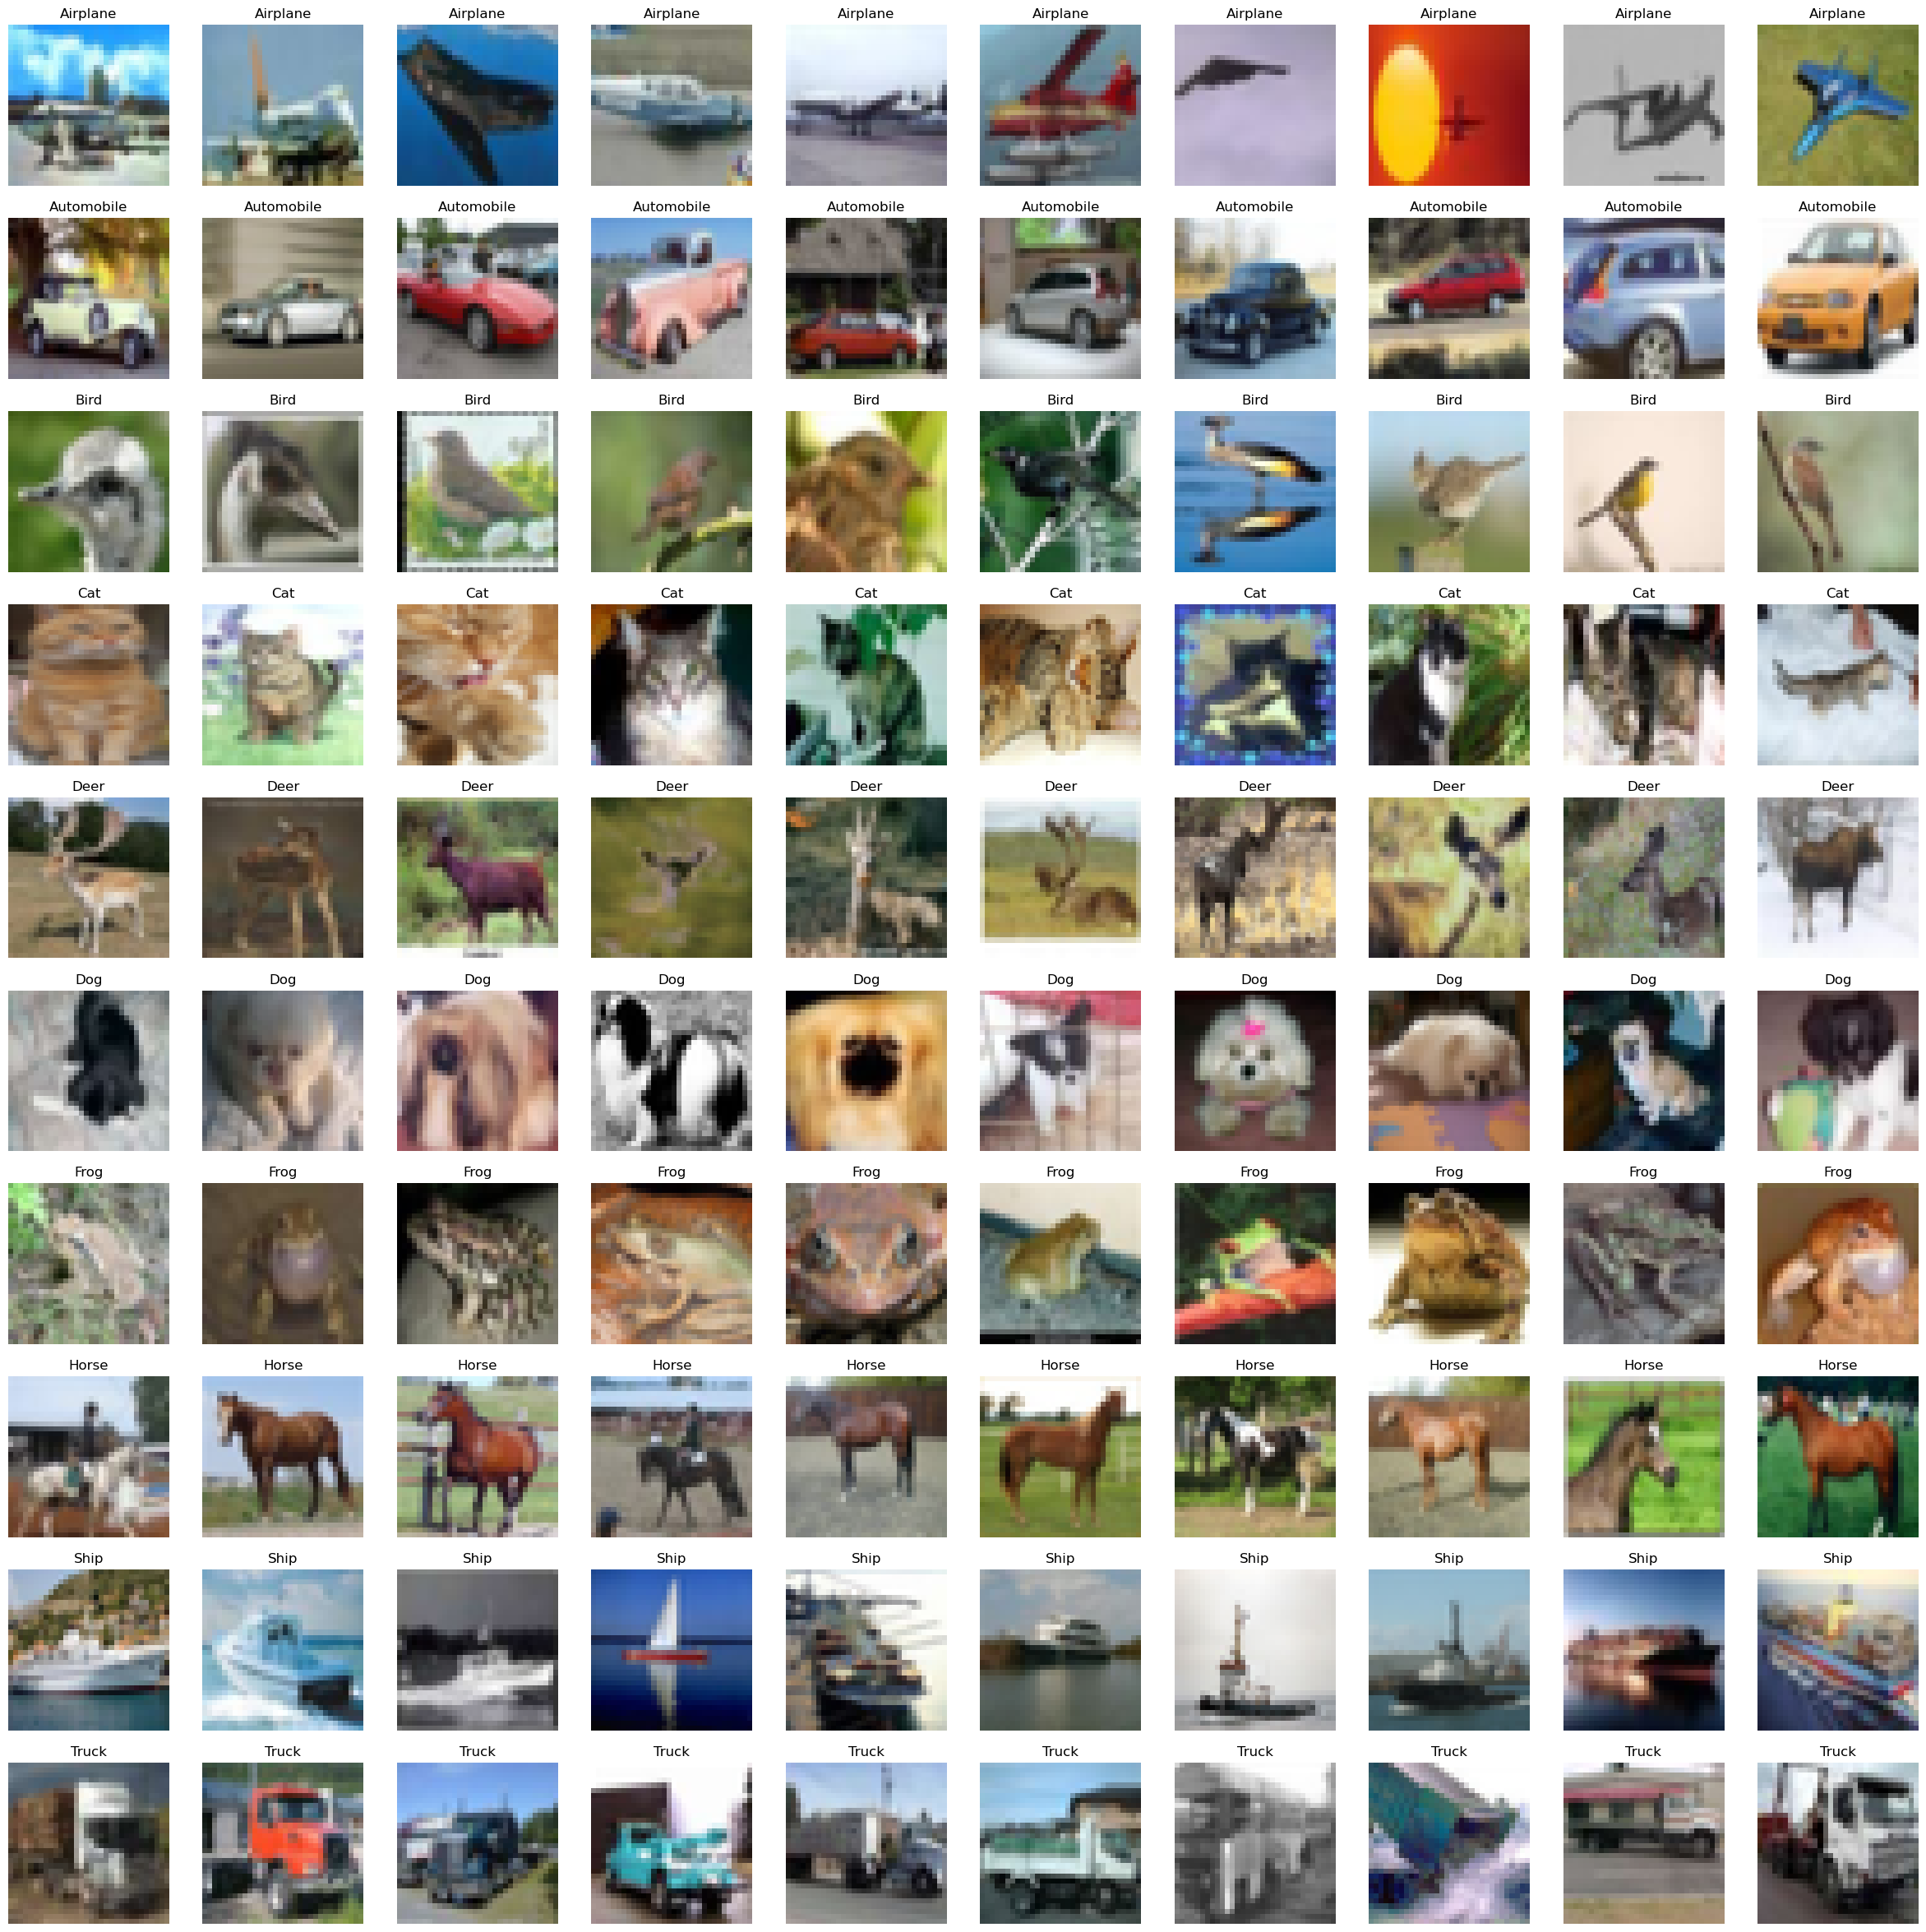

In [36]:
import numpy as np
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

# show sample unnormalized images
fig, ax = plt.subplots(10, 10, figsize=(30, 30))
for i in range(10):
    images = X_train[np.squeeze(y_labels == i)]
    random_index = np.random.choice(images.shape[0], 10, replace=False)
    images = images[random_index]
    label = class_labels[i]
    for j in range(10):
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[j])
        subplot.set_title(label)

plt.show()

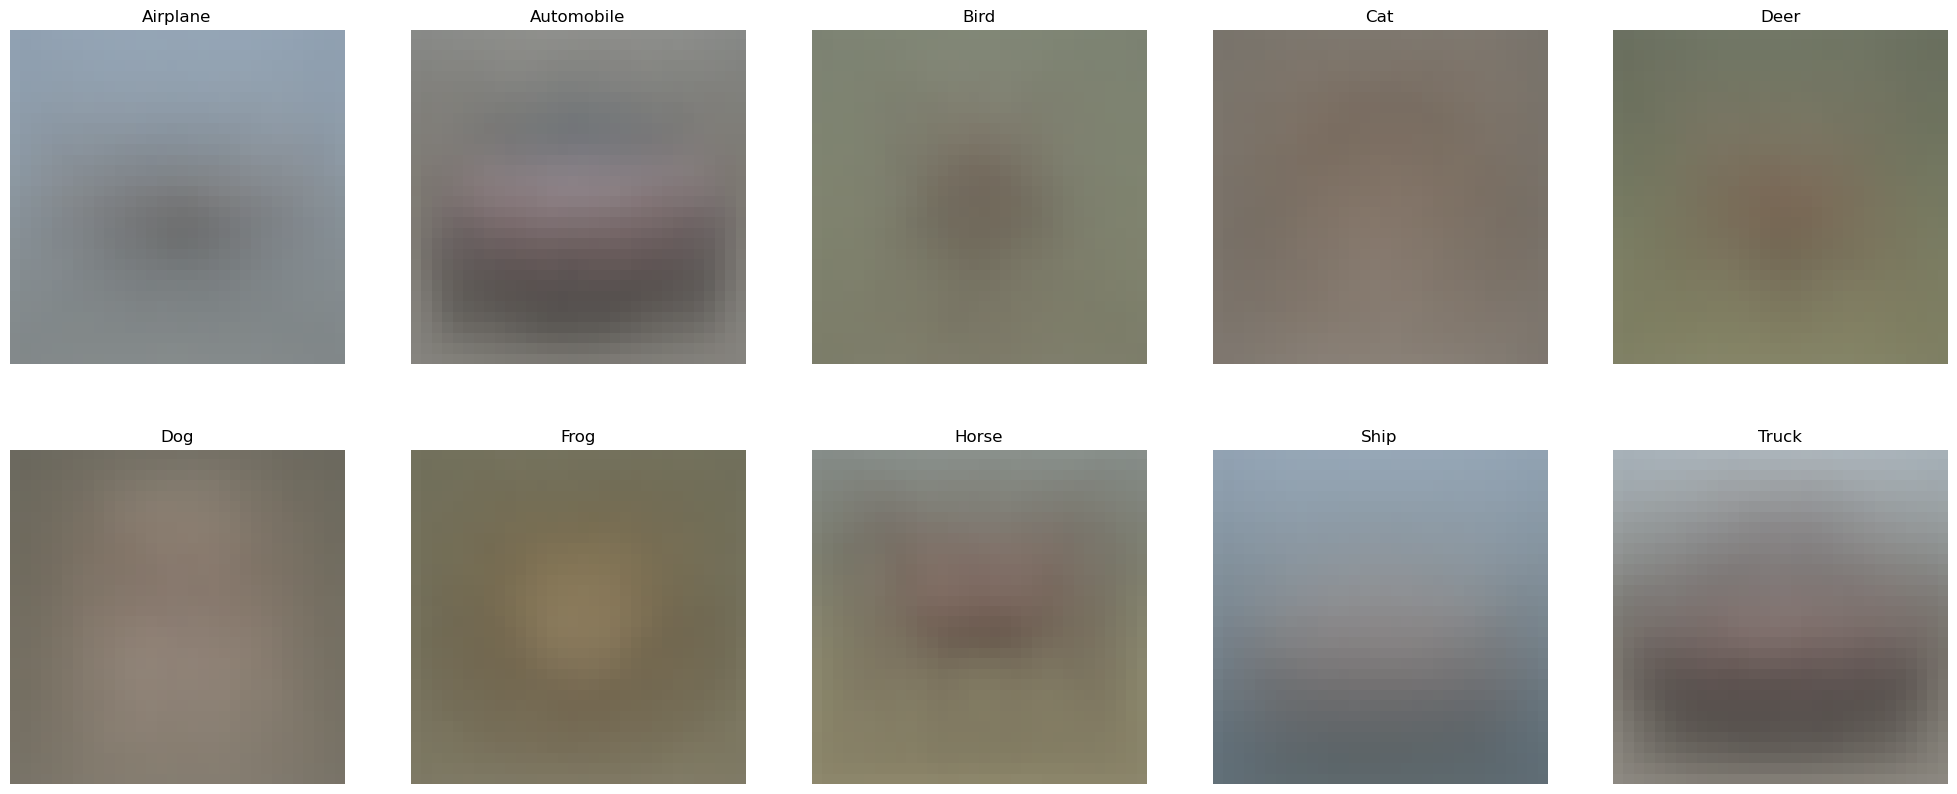

In [45]:
# pixel averaging
fig, ax = plt.subplots(2, 5, figsize=(25, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(X_train[np.squeeze(y_labels == idx)], axis=0) / 255
    subplot.imshow(avg_image)
    subplot.set_title(f"{class_labels[idx]}")
    subplot.axis("off")

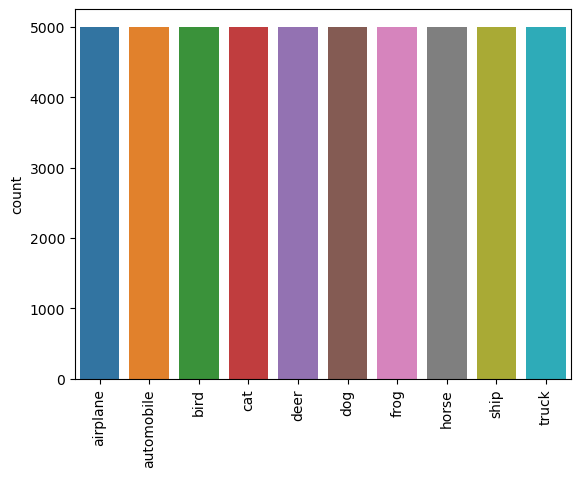

In [41]:
import pandas as pd
import seaborn as sns
df_eda = pd.DataFrame(y_labels, columns=['label'])
df_eda.value_counts()
plt.xticks(rotation=90)
sns.barplot(x=labels, y = df_eda.value_counts())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

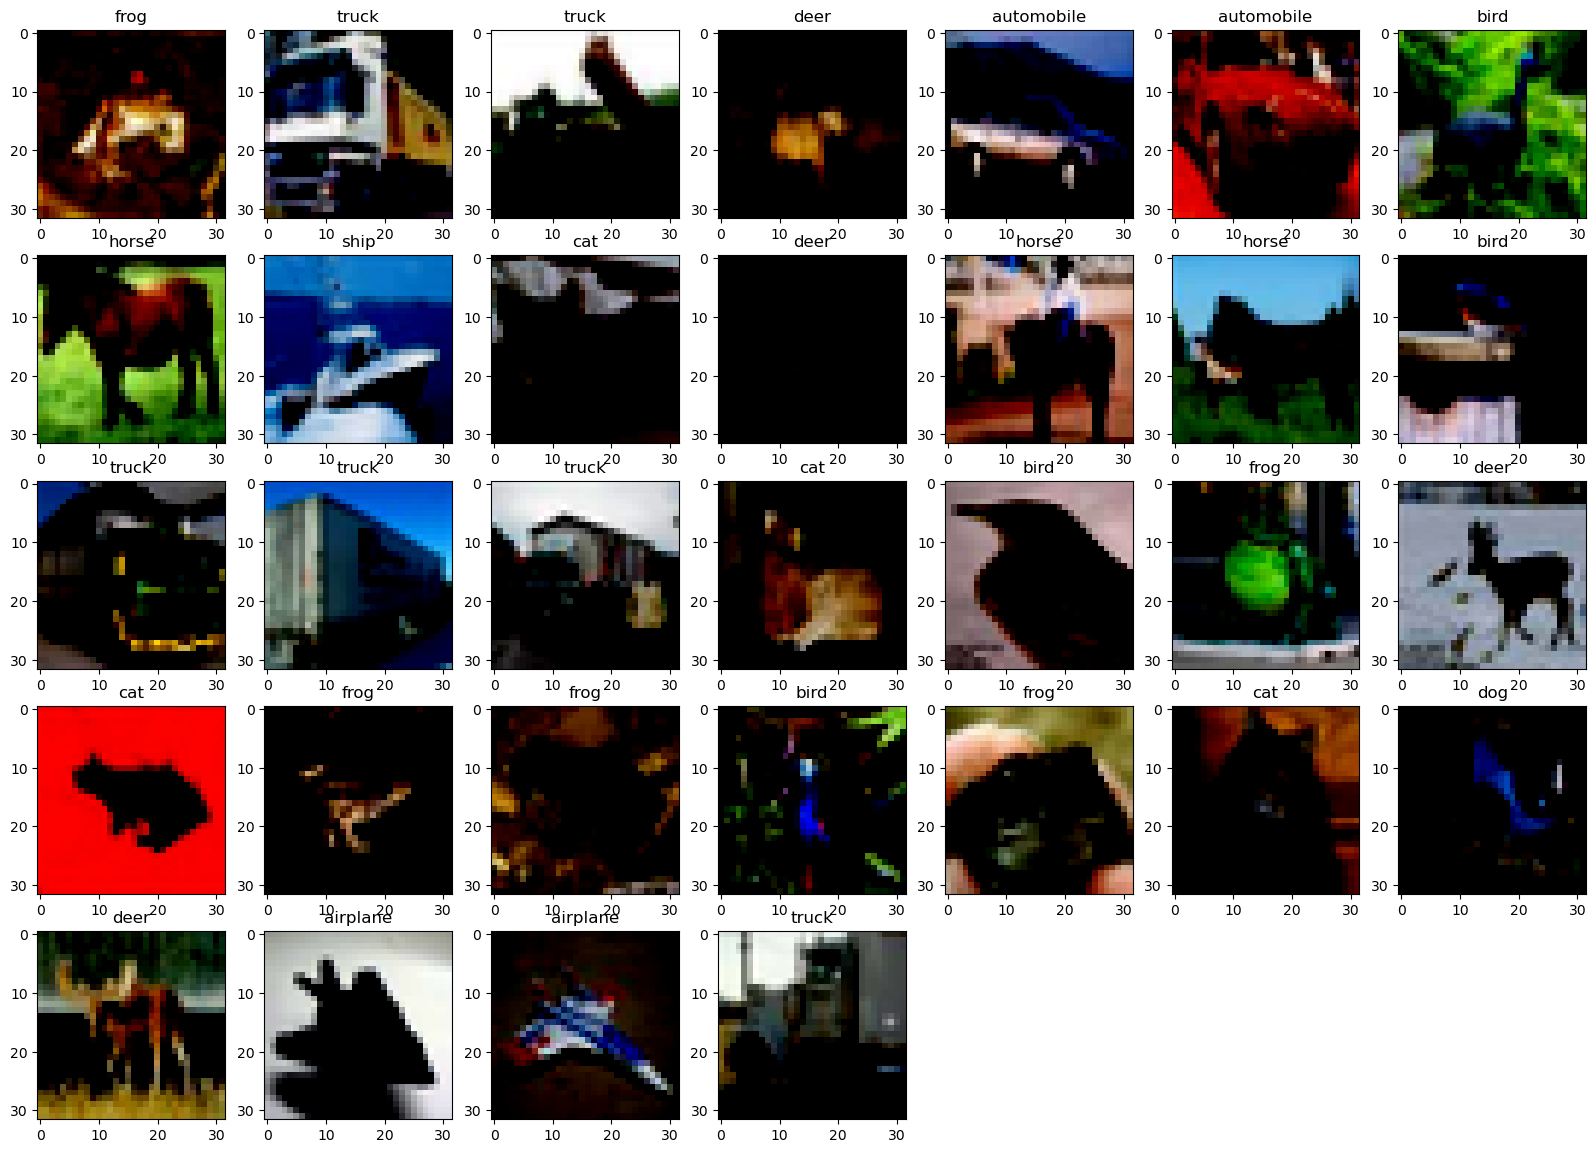

In [14]:
# Show normalized images
fig = plt.figure(0)
fig.set_size_inches(20, 20)
for i in range(0,32):
    fig.add_subplot(7, 7, i+1)
    plt.imshow(dataset[i])
    plt.title("{}".format(labels[int(y_labels[i])]))

## Data Augmentation

In [39]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

X_train_aug = data_augmentation(X_train)
X_train = np.concatenate((X_train, X_train_aug), axis=0)

In [ ]:
y_labels = np.concatenate((y_labels, y_labels), axis=0)

In [40]:
X_train.shape

(100000, 32, 32, 3)

## Build Model


In [15]:
# define the standalone discriminator model
def define_discriminator(input_shape=(32,32,3), lr=0.0002):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=input_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	#maybe put another dense
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model 

## Tune Disciminator - Learning Rate, Conv Layers, Dense Layers.

In [16]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model


## Tune numuber of layers and nodes, learning rate, alpha

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, lr=0.0002):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [18]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [20]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [21]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'CIFAR_imgs/generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [22]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy Real Image: %.0f%%, Fake Image: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(X_fake, epoch)
	# save the generator model weight file
	filename = 'CIFAR_weights/generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

## Train

In [23]:
# train the generator and discriminator
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	batches_per_epoch = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(batches_per_epoch):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			discriminator_loss1, _ = discriminator.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
			# update discriminator model weights
			discriminator_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			
			# update the generator via the discriminator's error
			generator_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, discriminator loss 1 : %.3f, discriminator loss 2 : %.3f generator loss : %.3f' %
				(i+1, j+1, batches_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [24]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 51ms/step
>1, 1/390, discriminator loss 1 : 0.681, discriminator loss 2 : 0.710 generator loss : 0.689
2/2 [==============================] - 0s 58ms/step
>1, 2/390, discriminator loss 1 : 0.426, discriminator loss 2 : 0.843 generator loss : 0.634
2/2 [==============================] - 0s 55ms/step
>1, 3/390, discriminator loss 1 : 0.139, discriminator loss 2 : 1.791 generator loss : 0.639
2/2 [==============================] - 0s 80ms/step
>1, 4/390, discriminator loss 1 : 0.160, discriminator loss 2 : 0.673 generator loss : 1.294
2/2 [==============================] - 0s 57ms/step
>1, 5/390, discriminator loss 1 : 0.178, discriminator loss 2 : 0.480 generator loss : 1.364
2/2 [==============================] - 0s 54ms/step
>1, 6/390, discriminator loss 1 : 0.127, discriminator loss 2 : 0.613 generator loss : 0.828
2/2 [==============================] - 0s 57ms/step
>1, 7/390, discriminator loss 1 : 0.180, discriminator loss 2 : 0.711 generato

KeyboardInterrupt: 

## Tune Model

## Load Model


4/4 [==============================] - 0s 55ms/step


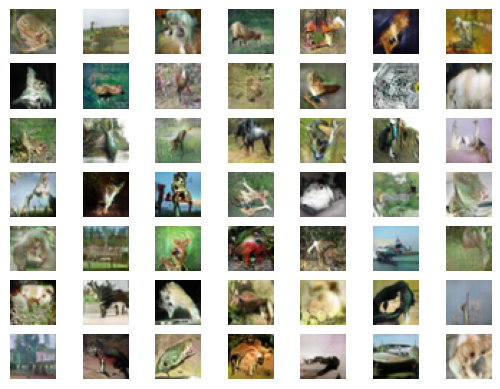

In [8]:
from tensorflow.keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	X_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	X_input = X_input.reshape(n_samples, latent_dim)
	return X_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()

# load model
model = load_model('./CIFAR_weights/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 7)

## Inception Score

In [4]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std		

In [11]:
latent_points = generate_latent_points(100, 5000)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# calculate inception score
is_avg, is_std = calculate_inception_score(X)
print('score', is_avg, is_std)

1/1 [==============================] - 1s 583ms/step
score 3.2336814 0.3711945
